In [1]:
# import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# read data from csv
portfolio_df = pd.read_csv("data/portfolio.csv")
profile_df = pd.read_csv("data/profile.csv")
transcript_df = pd.read_csv("data/transcript.csv")

In [3]:
# number of different offers type
portfolio_df["offer_type"].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

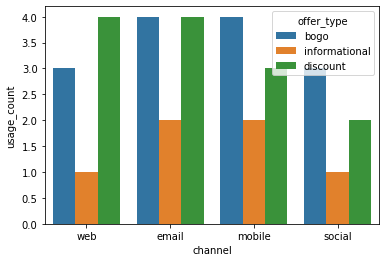

In [4]:
# most used channel for sending offers
channels = ["web", "email", "mobile", "social"]
usage_count = []
offer_list = []

offer_type = portfolio_df.offer_type.unique().tolist()
for o_type in offer_type:
    for chn in channels:
        offer_list.append(o_type)
        usage_count.append(portfolio_df[(portfolio_df["offer_type"] == o_type) & (portfolio_df[chn] == 1)].shape[0])

channels_df = pd.DataFrame({"channel": channels * len(offer_type), "usage_count": usage_count, "offer_type": offer_list})
sns.barplot(x="channel", y="usage_count", hue="offer_type", data=channels_df);

In [5]:
# average duration for offers
portfolio_df["duration"].mean()

6.5

In [6]:
# average and max reward for offers
# min reward is 0 for information offers
print("Average reward:", portfolio_df["reward"].mean())
print("Max reward:", portfolio_df["reward"].max())

Average reward: 4.2
Max reward: 10


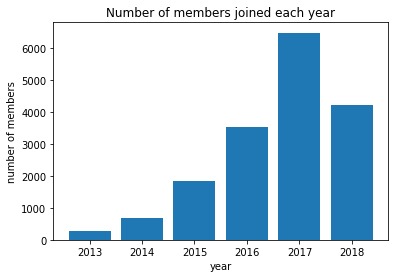

In [7]:
# number of members joined each year
profile_df["became_member_on"] = pd.to_datetime(profile_df["became_member_on"], format="%Y-%m-%d")
profile_df["year"] = profile_df["became_member_on"].apply(lambda date: date.year)

year_counts = profile_df["year"].value_counts()
plt.bar(year_counts.index.values, year_counts);
plt.xlabel("year");
plt.ylabel("number of members");
plt.title("Number of members joined each year");

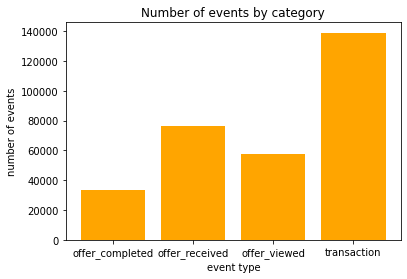

In [8]:
# number of events by category
event_cat = ["offer_completed", "offer_received", "offer_viewed", "transaction"]
event_counts = []
for ev in event_cat:
    event_counts.append(transcript_df[transcript_df["event_"+ev] == 1].shape[0])
plt.bar(event_cat, event_counts, color="orange");
plt.xlabel("event type");
plt.ylabel("number of events");
plt.title("Number of events by category");

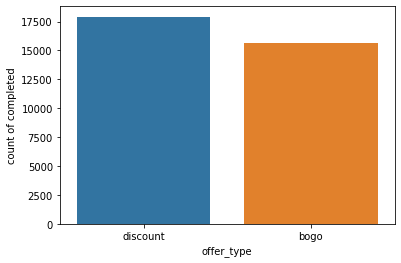

In [9]:
# What type of offer is most completed
offer_completed = transcript_df[transcript_df["event_offer_completed"] == 1]
offer_compl_count = offer_completed["value"].value_counts().reset_index()
offer_compl_count = offer_compl_count.join(portfolio_df[["id", "offer_type"]].set_index("id"), on="index")

offer_types = offer_compl_count["offer_type"].unique().tolist()
offer_counts = []
for o_type in offer_types:
    offer_counts.append(offer_compl_count[offer_compl_count["offer_type"] == o_type]["value"].sum())

ax = sns.barplot(x=offer_types, y=offer_counts);
ax.set(xlabel="offer_type", ylabel="count of completed");

In [10]:
# People who viewed the offer and completed
# groupby person and value
offers_df = transcript_df[(transcript_df["event_offer_viewed"] == 1) | (transcript_df["event_offer_completed"] == 1)]
offers_df = offers_df.groupby(by=["person", "value"])

viewed_completed = { "person": [], "offer_id": [] }

not_viewed_completed = { "person": [], "offer_id": []}

# create a dataframe of people who have viewed and completed the the offer
# We don't keep track if they completed the offer when they viewed based on timestamp
for name, group in offers_df:
    num_viewed = group[group["event_offer_viewed"] == 1].shape[0]
    num_completed = group[group["event_offer_completed"] == 1].shape[0]
    if  num_viewed > 0 and  num_completed > 0:
        viewed_completed["person"].append(name[0])
        viewed_completed["offer_id"].append(name[1])
    if num_viewed == 0 and  num_completed > 0:
        not_viewed_completed["person"].append(name[0])
        not_viewed_completed["offer_id"].append(name[1])
print("Number of people who viewed and completed the offer:", len(viewed_completed["person"]))
print("Number of people who did not view but completed the offer:", len(not_viewed_completed["person"]))

viewed_completed_df = pd.DataFrame(viewed_completed)
not_viewed_completed_df = pd.DataFrame(not_viewed_completed)

# add offer type for each offer id
viewed_completed_df = viewed_completed_df.join(portfolio_df[["id", "offer_type"]].set_index("id"), on="offer_id")
not_viewed_completed_df = not_viewed_completed_df.join(portfolio_df[["id", "offer_type"]].set_index("id"), on="offer_id")

Number of people who viewed and completed the offer: 24460
Number of people who did not view but completed the offer: 4536


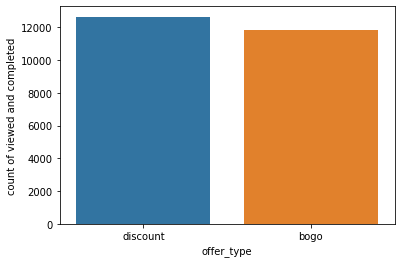

In [11]:
# What type of offer is most viewed and completed
ax = sns.barplot(x="index", y="offer_type", data=viewed_completed_df['offer_type'].value_counts().reset_index());
ax.set(xlabel="offer_type", ylabel="count of viewed and completed");

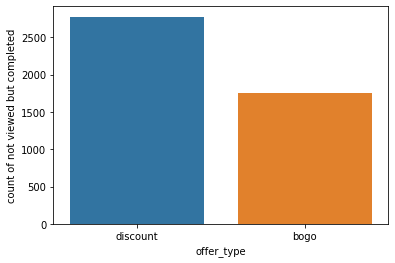

In [12]:
# What type of offer is not viewed but completed
ax = sns.barplot(x="index", y="offer_type", data=not_viewed_completed_df['offer_type'].value_counts().reset_index());
ax.set(xlabel="offer_type", ylabel="count of not viewed but completed");

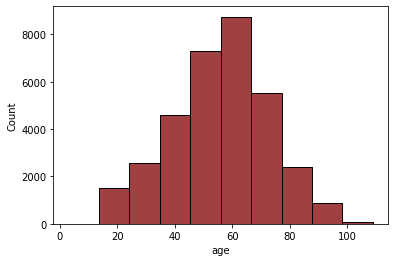

In [13]:
# Which age group of customers tend to complete the offers
offer_completed_age = offer_completed.join(profile_df[["id", "age"]].set_index("id"), on="person")
sns.histplot(data=offer_completed_age, x="age", bins=10, color="maroon");

In [14]:
# People who did not receive the offer, but completed

# group by offer and then person
offers_df = transcript_df[(transcript_df["event_offer_received"] == 1) | (transcript_df["event_offer_completed"] == 1)]
offers_df = offers_df.groupby(by=["value", "person"])

offer_ids = []
persons = 0
# for each offer separate users who received but did not complete offer
for name, group in offers_df:
    num_received = group[group["event_offer_received"] == 1].shape[0]
    num_completed = group[group["event_offer_completed"] == 1].shape[0]
    if  num_received == 0 and  num_completed > 0:
        offer_ids.append(name[0])
        persons += 1

print("Number of customers who did not receive the offer but completed:", persons)

# We don't have any data where customers have not received but completed the offer

Number of customers who did not receive the offer but completed: 0
